In [2]:
#Python 3.11.2
#Import packages
import scipy.integrate as scipy
import scipy.optimize as optimize
import scipy.stats as stats
import pandas as pd
import numpy as np
import pylab as pl
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import json # for pretty printing
import geopandas as gpd

import shutil
import sys
import os.path


In [3]:
# import logging

# console_handler = logging.StreamHandler()
# formatter = logging.Formatter("%(levelname)s:%(message)s")
# console_handler.setFormatter(formatter)
# logger = logging.getLogger("pyproj")
# logger.addHandler(console_handler)
# logger.setLevel(logging.DEBUG)

# logging.basicConfig(filename ='example.log', format="%(levelname)s:%(message)s", level=logging.DEBUG)

In [4]:
# logging.info("Start of the program")
# logging.debug("Start of the program")

Reading the shapefile

In [5]:
# Get the current working directory
data_folder = "MapScaniaSweden"
parishScania_path = "Parishes1720_1890.shp"
SkaneMap_path = "Skane1720_1890.shp"

SkaneMap = gpd.read_file(SkaneMap_path)
parishScaniaMap = gpd.read_file(parishScania_path)

In [6]:
len(parishScaniaMap)

437

In [7]:
parishScaniaMap.loc[2]

G_NAME            KRISTIANSTADS HELIGA TREFALDIGHETS FÖRSAMLING
GET_END_YE                                                 9999
GET_START_                                                  NaN
G_UNIT_TYP                                             SWE_KYRK
G_UNIT                                               10744052.0
G_SEQ                                                   98647.0
geometry      POLYGON ((4249757.033680517 3241445.338076748,...
Name: 2, dtype: object

Checking the projection to see if we can compute the area. In this case, we don't need to reproject our data since it's already on the plane.

In [8]:
parishScaniaMap.crs

<Projected CRS: EPSG:3034>
Name: ETRS89-extended / LCC Europe
Axis Info [cartesian]:
- N[north]: Northing (metre)
- E[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Türkiye (Turkey); United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Conformal 2001
- method: Lambert Conic Conformal (2SP)
Datum: Euro

In [9]:
parishScaniaMap.info(memory_usage='deep')

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   G_NAME      437 non-null    object  
 1   GET_END_YE  437 non-null    int64   
 2   GET_START_  44 non-null     float64 
 3   G_UNIT_TYP  437 non-null    object  
 4   G_UNIT      437 non-null    float64 
 5   G_SEQ       437 non-null    float64 
 6   geometry    437 non-null    geometry
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 88.3 KB


In [10]:
type(parishScaniaMap)

geopandas.geodataframe.GeoDataFrame

Computing and adding the areas in m2 and km2 to the DataFrame

In [11]:
from shapely.geometry import shape
def get_area(gpd: gpd.GeoDataFrame):
    for i in range(len(gpd)):
        gpd.loc[i, 'area_m2 '] = shape(gpd.loc[i, 'geometry']).area
        gpd['area_km2 '] = gpd['area_m2 ']/1000000
    return gpd

parishScaniaMap = get_area(parishScaniaMap)

In [17]:
parishScaniaMap.loc[parishScaniaMap['G_NAME']=='VIBY FÖRSAMLING']

,G_NAME,GET_END_YE,GET_START_,G_UNIT_TYP,G_UNIT,G_SEQ,geometry,area_m2,area_km2


Plotting interactive maps

In [138]:
import folium #we need folium to create the interactive maps
parishScaniaMap.explore(column = "G_NAME", 
                        tooltip = "G_NAME",
                        popup = True, #show all values in popup (on click)
                        cmap = "Set2", #color map
                        legend = False, #show legend
                        style_kwds = dict(color = "black"),#use black for borders
                       )

Compute and add the centroids as a new column to the original GeoDataFrame

In [143]:
def get_centroid(gpd: gpd.GeoDataFrame):
    for i in range(len(gpd)):
        gpd.loc[i, 'centroid'] = gpd.geometry.centroid[i]
    return gpd

parishScaniaMap = get_centroid(parishScaniaMap)

Plot the geometry and centroids

/opt/homebrew/lib/python3.11/site-packages/geopandas/plotting.py:656: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


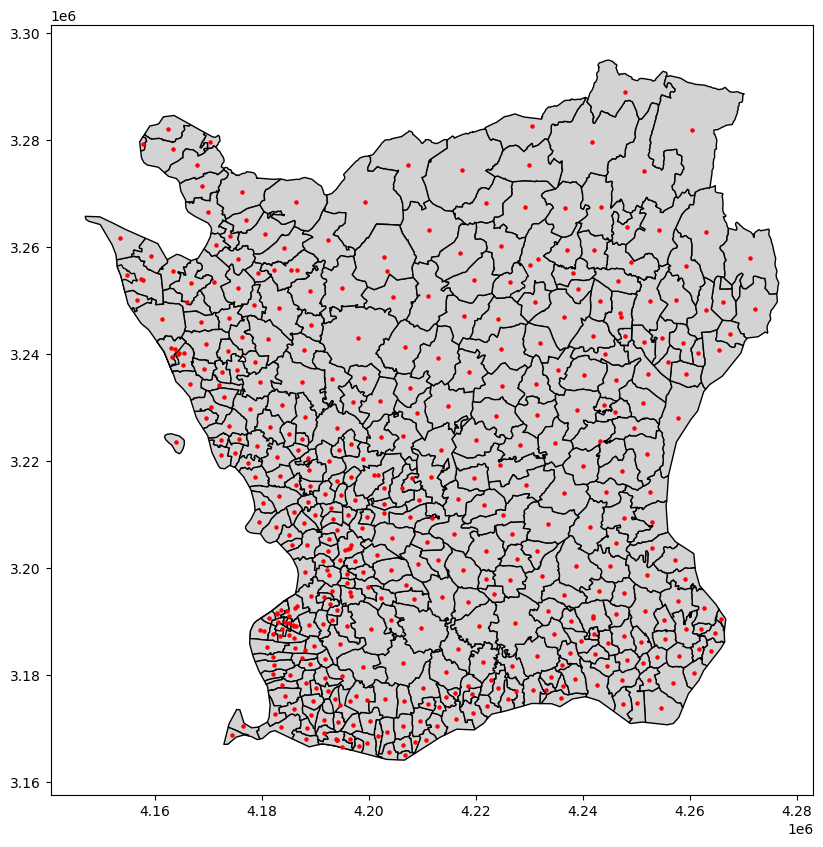

In [71]:
fig, ax = plt.subplots(figsize=(13,10))
parishScaniaMap.plot(ax=ax, column = "G_NAME", edgecolor='black', legend=False, color = 'lightgray')
parishScaniaMap.geometry.centroid.plot(ax=ax, marker = 'o', markersize = 5, label = 'centroid', color = 'red')
#plt.xlabel('Longitude')
#plt.ylabel('Latitude')
#plt.legend()
plt.show()


Compute the Euclidian distance in meters between centroids and shared borders. The polygons are projected onto the plane

In [166]:
def compute_info(gdp: gpd.GeoDataFrame,
                 column_name: str,
                 column_geometry: str = 'geometry',
                 column_centroid: str = 'centroid',
                 units: int = 1) -> dict:

    nPolygons = len(gdp)
    info = defaultdict(dict)

    for i in range(nPolygons):
        polygon_i = gdp.iloc[i][column_geometry]
        centroid_i = gdp.loc[i, column_centroid]
        name_i = gdp.iloc[i][column_name]

        for j in range(i+1, nPolygons):
            polygon_j = gdp.iloc[j][column_geometry]
            centroid_j = gdp.loc[j, column_centroid]
            name_j = gdp.iloc[j][column_name]

            distance = centroid_i.distance(centroid_j) / units * 1.0
            info["distance"][(i, j)] = distance  # in meters
            info["distance"][(j, i)] = distance  # in meters
            info["distance"][(name_i, name_j)] = distance  # in meters
            info["distance"][(name_j, name_i)] = distance  # in meters

            shared_border = polygon_i.intersection(polygon_j)
            info["shared_border"][(
                i, j)] = shared_border.length if shared_border != None else 0  # in meters
            info["shared_border"][(
                j, i)] = shared_border.length if shared_border != None else 0  # in meters
            info["shared_border"][(name_i, name_j)
                                  ] = info["shared_border"][(i, j)]  # in meters
            info["shared_border"][(name_j, name_i)
                                  ] = info["shared_border"][(j, i)]  # in meters

    return info


info = compute_info(
    parishScaniaMap, 'G_NAME')


In [167]:
info["shared_border"]

{(0, 1): 0.0,
 (1, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'TOREKOVS FÖRSAMLING'): 0.0,
 ('TOREKOVS FÖRSAMLING', 'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 2): 0.0,
 (2, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN',
  'KRISTIANSTADS HELIGA TREFALDIGHETS FÖRSAMLING'): 0.0,
 ('KRISTIANSTADS HELIGA TREFALDIGHETS FÖRSAMLING',
  'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 3): 0.0,
 (3, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'NORRA ÅSUMS FÖRSAMLING'): 0.0,
 ('NORRA ÅSUMS FÖRSAMLING', 'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 4): 0.0,
 (4, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'ÄSPHULTS FÖRSAMLING'): 0.0,
 ('ÄSPHULTS FÖRSAMLING', 'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 5): 0.0,
 (5, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'DJURRÖDS FÖRSAMLING'): 0.0,
 ('DJURRÖDS FÖRSAMLING', 'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 6): 0.0,
 (6, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'TRÄNE FÖRSAMLING'): 0.0,
 ('TRÄNE FÖRSAMLING', 'HOVS FÖRSAMLING L LÄN'): 0.0,
 (0, 7): 0.0,
 (7, 0): 0.0,
 ('HOVS FÖRSAMLING L LÄN', 'SKEPPARSLÖVS FÖRSAMLING'): 0.0,
 ('SKEPPARSLÖVS 

In [168]:
info["distance"][(2, 10)]

3483.9364790236477

To calculate the distance between two points given their latitude and longitude, you can use the Haversine formula. The Haversine formula (see https://en.wikipedia.org/wiki/Haversine_formula) calculates the great-circle distance between two points on a sphere, which is an approximation for the Earth's surface.

Getting access to the coordinates of each centroid:

In [ ]:
x_coord = gpd.GeoSeries(centroid[0]).iloc[0].x
y_coord = gpd.GeoSeries(centroid[0]).iloc[0].y
print([x_coord, y_coord])

[4162353.095562172, 3282055.860910411]


In [ ]:
def getCoordinates(centroidParishScania: gpd.GeoSeries):
    longitude = gpd.GeoSeries(centroidParishScania).iloc[0].x
    latitude = gpd.GeoSeries(centroidParishScania).iloc[0].y
    return [latitude,longitude]

print(getCoordinates(centroidParishScania[0]),getCoordinates(centroidParishScania[1]))


[3282055.860910411, 4162353.095562172] [3279338.7830117564, 4157750.0618345523]


Defining the Haversine distance:

In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    #c = 2 * math.asin(math.sqrt(a))

    # Earth radius in kilometers (mean radius)
    R = 6371.01

    # Calculate the distance
    distance = R * c

    return distance

# Example usage
distance = haversine_distance(40.7128, -74.0060, 34.0522, -118.2437)
print(distance, "kilometers")

haversine_distance(getCoordinates(centroidParishScania[0])[0], getCoordinates(centroidParishScania[0])[
                   1], getCoordinates(centroidParishScania[1])[0], getCoordinates(centroidParishScania[1])[1])



3935.7524322054765 kilometers


17205.486192064203

Using Haversine formula to compute the distance between the polygons' centroids:

In [ ]:
nPolygons = len(parishScaniaMap)
Haversine_distance_matrix = np.zeros((nPolygons,nPolygons))

for i in range(len(centroid)):
    for j in range(i + 1, len(centroid)):
        distance = haversine_distance(getCoordinates(centroid[i])[0], getCoordinates(centroid[i])[
                                      1], getCoordinates(centroid[j])[0], getCoordinates(centroid[j])[1])
        Haversine_distance_matrix[i, j] = distance
        Haversine_distance_matrix[j, i] = distance
        #print(Haversine_distance_matrix)
        #print(f"The Haversine distance between centroid {i+1} and centroid {j+1} is {distance} meters")

In [ ]:
# Create a dataframe from the distance matrix
#Haversine_distance_matrix = pd.DataFrame(Haversine_distance_matrix)

#Rename the columns and rows
#Haversine_distance_matrix.columns = labels
#Haversine_distance_matrix.rows = labels

#Print the updated distance matrix
#Haversine_distance_matrix.head()

# Export the distance matrix to a csv file
#Haversine_distance_matrix.to_csv('Haversine_distance_matrix.csv', encoding='utf-8', index=True, header=True)

Plotting

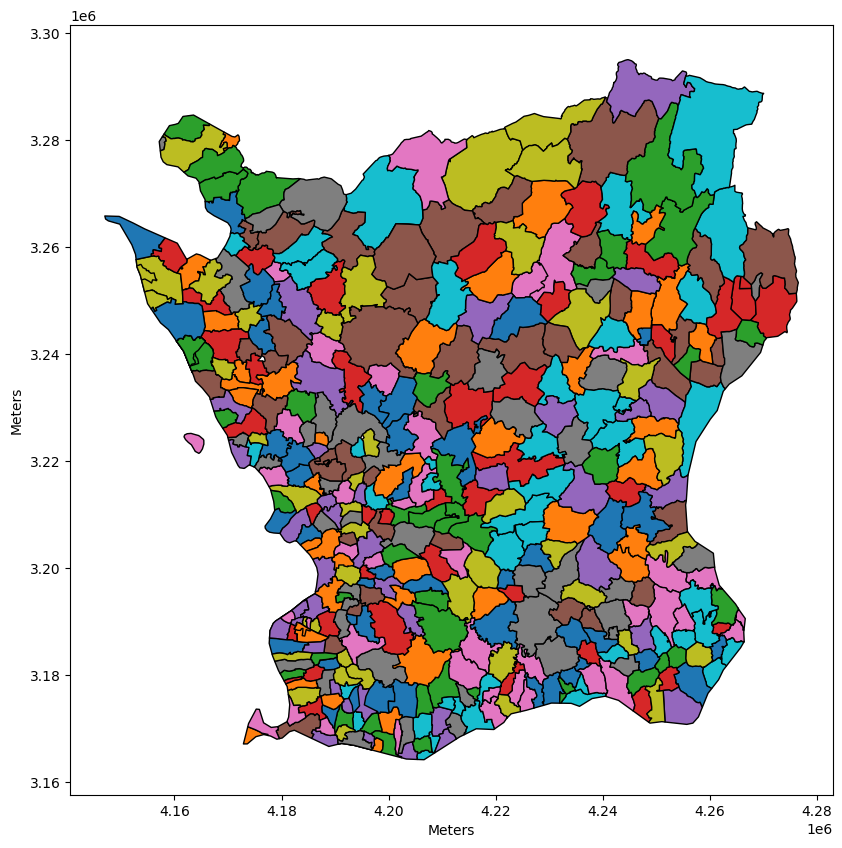

In [ ]:
fig,ax = plt.subplots(figsize=(13,10))
parishScaniaMap.plot(ax=ax, column = "G_NAME", edgecolor='black', legend=False)
plt.xlabel('Meters')
plt.ylabel('Meters')
# legend = ax.get_legend()
# legend.set_bbox_to_anchor((1, 0.2))
plt.show()

In [ ]:
parishScaniaMap.columns

Index(['G_NAME', 'GET_END_YE', 'GET_START_', 'G_UNIT_TYP', 'G_UNIT', 'G_SEQ',
       'geometry', 'area_m2 ', 'area_km2 '],
      dtype='object')

<Axes: >

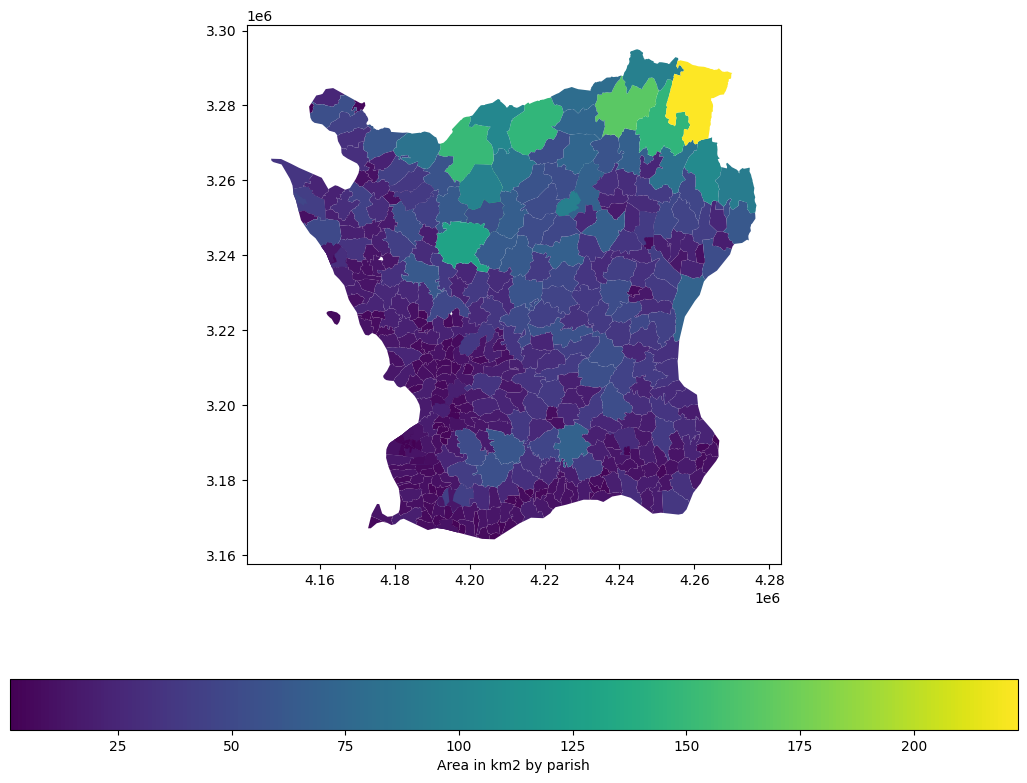

In [ ]:
fig,ax = plt.subplots(figsize=(13,10))
parishScaniaMap.plot(column = "area_km2 ", ax=ax,legend=True,
                     legend_kwds={'label': "Area in km2 by parish", 'orientation': "horizontal"}
                     )